# **Data Cleaning and EDA** 

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize

import re

In [2]:
ev_cars = pd.read_csv('../data/ev_cars_unclean.csv')

ev_cars.head()

,subreddit,title,id
0,cars,Need help for an article,10b28x0
1,cars,We have a 2014 Nissan Rogue. Just found out ab...,10b1jn0
2,cars,Audi manual transmission?,10b14rq
3,cars,How much would a paint job cost to cover up tw...,10b1112
4,cars,What car is Jeezy riding in this music video? ...,10b0zwu


In [3]:
ev_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8660 entries, 0 to 8659
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  8660 non-null   object
 1   title      8659 non-null   object
 2   id         8660 non-null   object
dtypes: object(3)
memory usage: 203.1+ KB


## Removing inexplicable classes

In [4]:
#Checking to see the unique values in my subreddit column
#expected to see just the two subreddits of interest but I notice three others
ev_cars['subreddit'].unique()

array(['cars', 'u_daleelsayarat-cars', 'u_alaimran-cars',
       'u_I-deeply-Love-Cars', 'electricvehicles'], dtype=object)

In [5]:
#Investigating this further
ev_cars[(ev_cars.subreddit=='u_alaimran-cars')|(ev_cars.subreddit=='u_daleelsayarat-cars')|(ev_cars.subreddit=='u_I-deeply-Love-Cars')]

,subreddit,title,id
481,u_daleelsayarat-cars,إيجاد اقرب محطة ديزل من موقعي بالآيفون والأندر...,108c1uk
608,u_alaimran-cars,Location de voiture Agadir AlAimran Cars,107lcjy
612,u_alaimran-cars,Al Aimran Cars : Location de voiture Agadir pa...,107l3dd
637,u_daleelsayarat-cars,مرسيدس جي كلاس 2022 من الداخل,107gnvl
638,u_daleelsayarat-cars,هذا هو الزيت الموصى به من شركة هيونداي توسان,107gf14
1457,u_daleelsayarat-cars,Is 5W30 Good For High Mileage Cars? The Comple...,1035540
1569,u_daleelsayarat-cars,إليك 6 عيوب سيارات الديزل التي ستحسم قرار شرائ...,102ibf8
3114,u_daleelsayarat-cars,أفضل منظف تابلوه السيارة 2022 كيف تختاره وكم سعره,zt9gb3
3446,u_daleelsayarat-cars,How to Learn Comsol Multiphysics (Step-By-Step...,zrdyo3
3596,u_daleelsayarat-cars,How Solar Energy Availability Problems Affect ...,zqk700


This is weird. I requested for posts from the `cars` subreddit but in the above instances, the name of the subreddit appeared as `u_daleelsayarat-cars`, `u_alaimran-cars` or `u_I-deeply-Love-Cars`. I researched briefly on Reddit and Google, but did not find much to tell me what this means. Those appear to be names of Reddit users. Notice how they start with the letter `u`.  I have no idea why they show up here when I pulled from the `cars` subreddit. I am not very familiar with the Reddit platform, and the number of rows where this happens is not very large. So I am just going to remove those rows from my dataset. 

In [6]:
#Removing rows where subreddit is 'u_daleelsayarat-cars', 'u_alaimran-cars' and 'u_I-deeply-Love-Cars' from my dataset
ev_cars = ev_cars[(ev_cars.subreddit!='u_alaimran-cars')&(ev_cars.subreddit!='u_daleelsayarat-cars')&(ev_cars.subreddit!='u_I-deeply-Love-Cars')]
ev_cars.shape


(8645, 3)

## Dropping a single row with a null value
Also, when I checked `.info()` earlier, I noticed that there was one less row in the `title` column compared to the `subreddit` column. I am going to drop the row where the `title` is null.

In [7]:
ev_cars.isnull().sum()

subreddit    0
title        1
id           0
dtype: int64

In [8]:
#Dropping the row where title is null
ev_cars.dropna(inplace=True)
print(f'There are now {ev_cars.shape[0]} rows in my dataset')

There are now 8644 rows in my dataset


## Removing non-english alphabets
Some of the characters in the title column are in non-English alphabets like Arabic and Chinese. I noticed this when I took a cursory look at my data. You would also notice some of those characters in a previous cell above where I showed the data in those rows I wanted to delete. This is not helpful for my analysis, and so I am going to drop `non-ascii` rows. 

In [9]:
ev_cars = ev_cars[ev_cars['title'].map(lambda x: x.isascii())]
print(f'There are now {ev_cars.shape[0]} rows in my dataset')

There are now 7813 rows in my dataset


In [10]:
ev_cars.tail()

,subreddit,title,id
8655,electricvehicles,China EV Sales: BYD Achieves All-Electric Mile...,ylfi28
8656,electricvehicles,BMW i3 - considering buying a 2015,yles4u
8657,electricvehicles,DRAG RACING OUR GOLF CARTS! They say electric ...,ylcrgv
8658,electricvehicles,Ceer Is Saudi Arabia's First Homegrown EV Bran...,ylcims
8659,electricvehicles,Quantumscape Announces New Cell Format for Sol...,ylchfm


My dataset is now massively depleted. But at 7813 rows, I still have substantial data in theory to derive good models, so there is no need to collect more data at this point. 

However, I know that I won't have a 1:1 split of course because my `electricvehicles` dataset did not have as much data as I requested in the first place, plus the fact that I have now deleted several rows above. So I am going to check out the new proportions between the subreddit classes in my data.

## Count of data observations from each class in my dataset

In [11]:
#My dataset is unbalanced with there being 16% more cars posts than electricvehicles posts
ev_cars.subreddit.value_counts(normalize=True)

cars                0.582491
electricvehicles    0.417509
Name: subreddit, dtype: float64

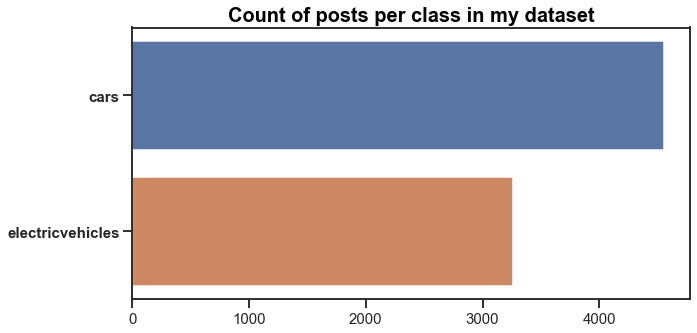

In [12]:
sns.set_theme(rc={'figure.figsize': (10,5)}, style='ticks', context='talk')
plt.figure(figsize=(10,5))
s = ev_cars.subreddit.value_counts()
sns.barplot(x = s.values, y=s.index)
plt.title('Count of posts per class in my dataset', {'fontsize':20, 'color': 'black', 'fontweight': 'bold'})
plt.xticks(size=15)
plt.yticks(size=15, fontweight='bold');

I still have at least 3000 observations in each of my classes. That's not a bad number. Hopefully, there are no more reasons to remove rows. The proportions above (58% for the majority class) would form the baseline for my evaluation metric of choice - `accuracy`. I am not yet at that point, but noting it.

## EDA on word count and character count of posts

## Creating two new columns

I am going to create two new columns in my `ev_cars` dataset. 
- `title_length` will contain the number of characters in the title posts for each submission.
- `title_word_count` will contain the number of words in the title posts for each submission. 

In [13]:
ev_cars['title_length'] = ev_cars['title'].str.len()
ev_cars['title_word_count'] = ev_cars['title'].str.split().str.len()

ev_cars.head()

,subreddit,title,id,title_length,title_word_count
0,cars,Need help for an article,10b28x0,24,5
1,cars,We have a 2014 Nissan Rogue. Just found out ab...,10b1jn0,159,31
2,cars,Audi manual transmission?,10b14rq,25,3
3,cars,How much would a paint job cost to cover up tw...,10b1112,66,16
4,cars,What car is Jeezy riding in this music video? ...,10b0zwu,65,14


## Checking distributions of the character lengths for `r/cars` and `r/electricvehicles`.

In [14]:
#assigning rows belonging to electricvehicles and cars subreddits to `ev` and `cars` respectively
ev = ev_cars[ev_cars['subreddit']=='electricvehicles']
cars = ev_cars[ev_cars['subreddit']=='cars']

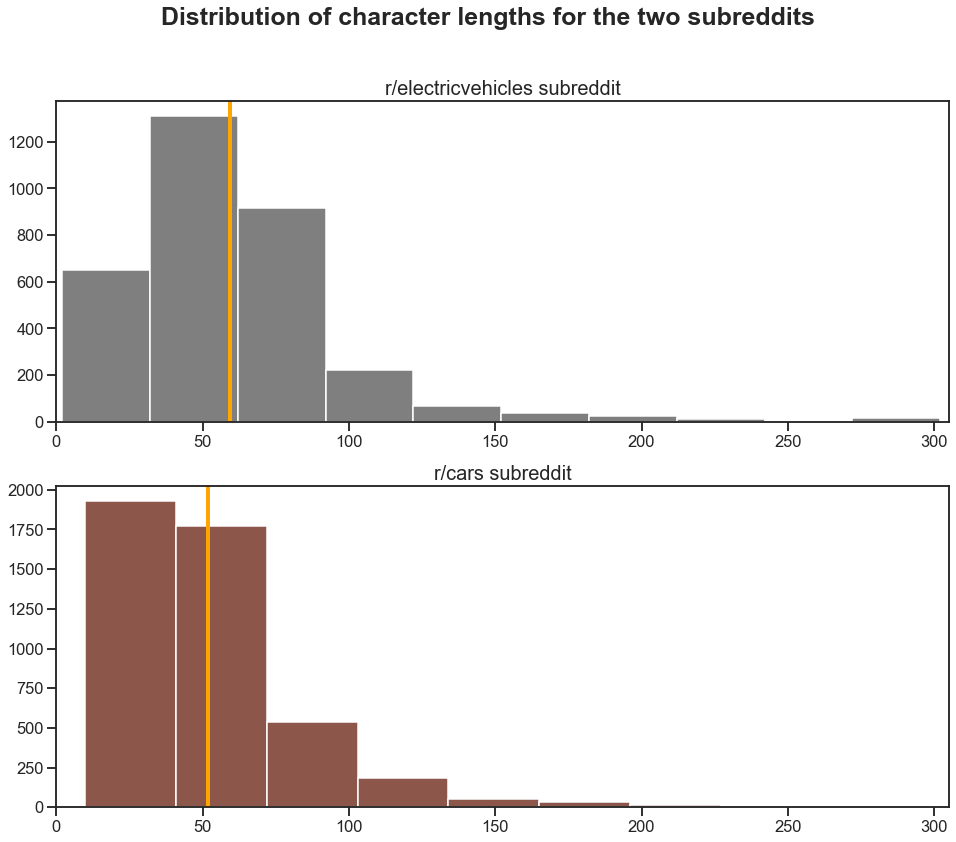

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,13))
ax1.hist(ev['title_length'], color='tab:grey')
ax2.hist(cars['title_length'], color='tab:brown')
ax1.set_title('r/electricvehicles subreddit', {'fontsize':20})
ax2.set_title('r/cars subreddit', {'fontsize':20})
ax1.axvline(linewidth=4, color='orange', x=ev['title_length'].mean())
ax2.axvline(linewidth=4, color='orange', x=cars['title_length'].mean())
ax1.set_xlim(0,305)
ax2.set_xlim(0,305)
ax1.grid(False)
ax2.grid(False)
fig.suptitle('Distribution of character lengths for the two subreddits', fontsize=25, fontweight='bold')
plt.savefig('../images/length_hist.png', dpi=300);

**Takeaways from above**:
- From the distributions above, users in the `electricvehicles` subreddit used more characters in their titles on average compared to the users in `cars` subreddit. Notice the orange vertical line indicating the means.
- Both distributions have a right skew and both have a lot of outlying values.

### Below are the 5 lengthiest posts based on character lengths in the two subreddits of interest.

In [16]:
#these two variables contain the top 5 lengths in the title_length column from each of the two classes 
top_ev_lengths = ev['title_length'].sort_values(ascending=False).head()
top_car_lengths = cars['title_length'].sort_values(ascending=False).head()

In [17]:
#Top 5 posts based on length of characters in the electricvehicles subreddit
longest_evs=[ev['title'][i] for i in top_ev_lengths.index]

longest_evs

['Used Cars For Sale In India | Second Hand Cars In India | Cars360 . Visit- www.cars360.co/landing.php Call- 9910080365 . Used cars for sale by owner in india. Find the best Second hand cars price &amp; valuation In india! Sell your used Maruti Suzuki Swift, Toyota Innova, Mahindra, .etc Verified secon',
 'Sell Your Car At Best Price | Instant Payment For Your Car . Book free home inspection - www.cars360.co/landing.php Call- 9910080365 . Sell your used cars online at the best price. Get an instant valuation of second-hand cars in 3 easy steps. Free Doorstep Evaluation. &amp; Same Day Payment. . #sellc',
 'I stay in a flat the UK, and got in touch with my building adm regarding installation of EV charger in my private parking bay, they came back saying it is not possible due to the location and cabling, whereas there are other parking bays where there are chargers installed. Can someone please advice?',
 'Lexus UX 300e . . . . . . . .#lexus #lexusnation #lexuslove #Lexus #lexuschallen

In [18]:
#Top 5 posts based on length of characters in the cars subreddit
longest_cars=[cars['title'][i] for i in top_car_lengths.index]
longest_cars

['Can you help me connect this car alternator to this speed controller I found on AliExpress? And which wires should be connected? Speed controller: https://www.google.com/url?sa=t&amp;source=web&amp;rct=j&amp;url=https://m.aliexpress.com/item/4000620063009.html&amp;ved=2ahUKEwjcjsGJzr38AhXHlIsKHUhHDqIQFnoECBUQAQ&amp;usg',
 'Video of transmission acting up. In sports mode clip, seems like slipping in last two gears. In eco mode clip, sound does not match up with engine. As you can see the oil temp is normal. This car only has 3k ml. Does anyone know what up with this? Should be noted that the videos are merged together.',
 "need help finding a part. vehicle is an 04 dodge ram 1500 RWD. I have been looking everywhere from O'Reilly's to Rockauto to Ebay and all day long I can find the upper but I cannot locate the lower front spring insulator/ seat or whatever you call the rubber ring the spring sits in. nobody has one.",
 'A testament to how bulletproof the BMW E36 engines really are. T

## Checking distributions of the word counts for `r/cars` and `r/electricvehicles`.

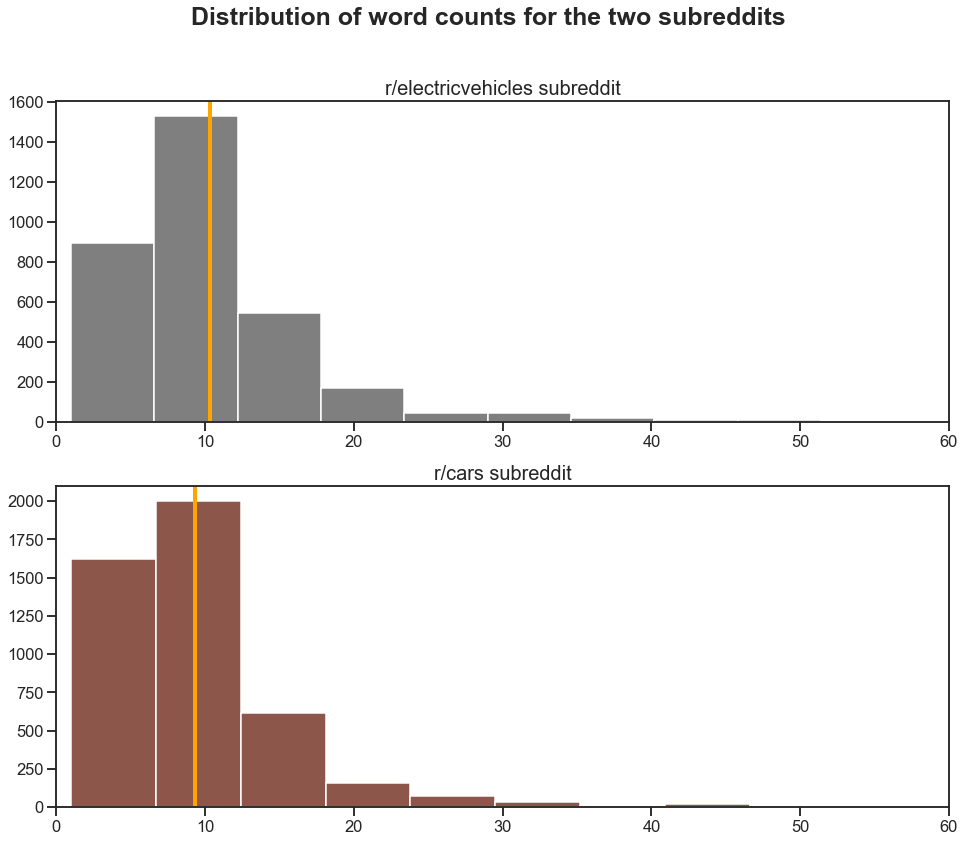

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,13))
ax1.hist(ev['title_word_count'], color='tab:grey')
ax2.hist(cars['title_word_count'], color='tab:brown')
ax1.set_title('r/electricvehicles subreddit', {'fontsize':20})
ax2.set_title('r/cars subreddit', {'fontsize':20})
ax1.axvline(linewidth=4, color='orange', x=ev['title_word_count'].mean())
ax2.axvline(linewidth=4, color='orange', x=cars['title_word_count'].mean())
ax1.set_xlim(0,60)
ax2.set_xlim(0,60)
fig.suptitle('Distribution of word counts for the two subreddits', fontsize=25, fontweight='bold')
plt.savefig('../images/word_count_hist.png', dpi=300);

**Takeaways from above**:

- Again, it appears from the distribution above that users in the `electricvehicles` subreddit used more words in their titles on average compared to the users in cars subreddit. However, the difference is not as pronounced as it was with the length of characters. Notice the orange vertical line indicating the means.
- Similarly, both distributions in this case have a right skew and have a lot of outlying values.

## Some summary statistics

Below I look at the `.describe()` for the two subreddits and it basically confirms the above. The mean `title_length` was about 59 characters for `electricvehicles` compared to 52 for `cars`. However the mean word count was 10 words in `electricvehicles` vs. 9 words in `cars` - a very small difference. There is a case to be made that the length of characters may be more useful in separating these classes compared to the word counts. I may include this eventually in my model. Another point of similarity as shown in the summary statistics below is the spread of the two classes which are very close to each other for both character lengths (37 vs 35) and word counts (7 vs 6).

In [20]:
ev.describe()

,title_length,title_word_count
count,3262.000000,3262.000000
mean,59.463519,10.323115
std,36.919777,6.543264
min,2.000000,1.000000
25%,36.000000,6.000000
50%,54.000000,9.000000
75%,73.000000,13.000000
max,302.000000,57.000000


In [21]:
cars.describe()

,title_length,title_word_count
count,4551.000000,4551.000000
mean,51.950121,9.312679
std,34.852851,6.448205
min,10.000000,1.000000
25%,29.000000,5.000000
50%,46.000000,8.000000
75%,64.000000,11.000000
max,320.000000,58.000000


### Below are the longest 5 posts based on word counts in the two subreddits of interest.

In [22]:
top_ev_words = ev['title_word_count'].sort_values(ascending=False).head()
top_car_words = cars['title_word_count'].sort_values(ascending=False).head()

In [23]:
#Top 5 posts based on word counts in the electricvehicles subreddit
longest_counts_evs=[ev['title'][i] for i in top_ev_words.index]

longest_counts_evs

['Some Ford dealerships have decent End of Model Year deals on the Escape PHEV. After failing to get one last year due to 8-10k markups, I finally picked one up for $4k under MSRP plus full value for my 22 Bolt EUV trade-in. Full $7500 tax credit as well. No longer reliant on EA for road trips.',
 'Building a House: Where should I place the EV outlet (only 1) in the garage, currently have a tesla Model 3 (charge port driverside rear). Planning to park the tesla back in on the right. Planning on getting another EV in the future so trying to figure out the best place to put the charger.',
 "Question to those who own a Tesla in a state that doesn't sell Teslas or have service centers- What've you done when you need service? Do you have to drive to a physical location even if it's far away? Have you used Tesla's mobile service? Do they really not let you change a tire?",
 'I stay in a flat the UK, and got in touch with my building adm regarding installation of EV charger in my private park

In [24]:
#Top 5 posts based on word counts in the cars subreddit
longest_counts_cars=[cars['title'][i] for i in top_car_words.index]
longest_counts_cars

['hey; im trying to change my shift knob on my 2011 v70, i want to change it to a weighted shifter since my original one is cracking. does anyone know if it is easy to remove and install a new one. If anyone has any links to a weighted one like the ones mishimoto sells, would be appreiciated,',
 'Video of transmission acting up. In sports mode clip, seems like slipping in last two gears. In eco mode clip, sound does not match up with engine. As you can see the oil temp is normal. This car only has 3k ml. Does anyone know what up with this? Should be noted that the videos are merged together.',
 "need help finding a part. vehicle is an 04 dodge ram 1500 RWD. I have been looking everywhere from O'Reilly's to Rockauto to Ebay and all day long I can find the upper but I cannot locate the lower front spring insulator/ seat or whatever you call the rubber ring the spring sits in. nobody has one.",
 "2015 Outback owner here. On NYE while driving to visit my mom at the hospital I had to drive 

### How many unique users in our samples from each subreddit?

Starting with `r/electricvehicles`

In [25]:
ev['id'].nunique()

3262

Then `r/cars`

In [26]:
cars['id'].nunique()

4551

In [27]:
ev.shape

(3262, 5)

In [28]:
cars.shape

(4551, 5)

**Answer: I cannot get number of unique users from my dataset.**

When I requested this `id` column I assumed that it reflected the id's of the unique posters. However, notice that when I called `.nunique`, the number I got is the same as the number of rows in each of our subreddit samples. This implies that the id's reflect uniqueness of posts and not uniqueness of individuals because it is unlikely that every poster only posted once in our sample. I checked further online and [confirmed](https://www.reddit.com/r/help/comments/3p43su/what_is_a_reddit_id/) on the Reddit page that the `id` as obtained here is not unique per individual, but unique per post. So every post has a unique id, and that is what I obtained. 

Since my main reason for requesting the IDs was to check unique users, the `id` column no longer serves any purpose for me and I'll drop it from my combined dataframe - `ev_cars` below. I'll also now drop the `title_length` and `title_word_count` columns.

In [29]:
ev_cars.drop(columns=['id', 'title_length', 'title_word_count'], inplace=True)
ev_cars.head()

,subreddit,title
0,cars,Need help for an article
1,cars,We have a 2014 Nissan Rogue. Just found out ab...
2,cars,Audi manual transmission?
3,cars,How much would a paint job cost to cover up tw...
4,cars,What car is Jeezy riding in this music video? ...


## Dropping duplicate rows from our dataframe 

In [30]:
ev_cars.shape

(7813, 2)

In [31]:
ev_cars.drop_duplicates(inplace=True, ignore_index=True)
ev_cars.shape

(7447, 2)

Notice how the number of observations have now reduced from 7813 to 7447. This is a big decrease from the 8660 we started with. 
However, I still think this is a large enough sample. So, at this point there still isn't a need to get more data. Again, I'll like to see the counts for our two classes in the reduced dataset. 

In [32]:
ev_cars.subreddit.value_counts(normalize=True)

cars                0.580905
electricvehicles    0.419095
Name: subreddit, dtype: float64

Despite the number of dropped observations. The proportion of our dataset is still exactly the same - 58% vs 42%. 
And as can be seen below, we still have at least 3000 observations in each class - enough, in my opinion, to get a good model. 

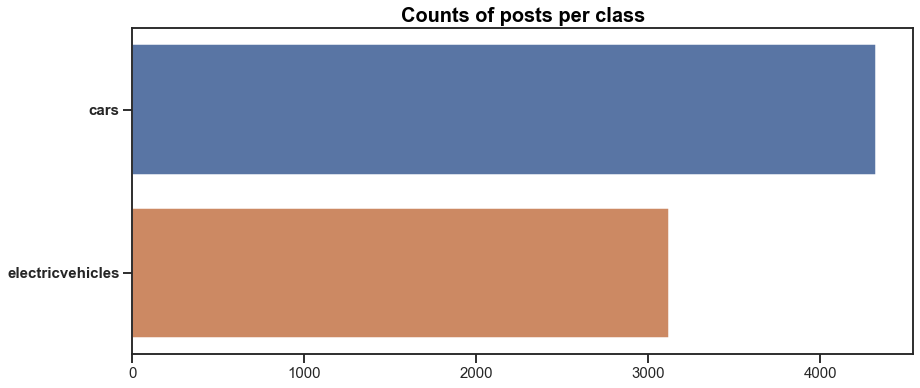

In [33]:
plt.figure(figsize = (14, 6))
s = ev_cars.subreddit.value_counts()
sns.barplot(x = s.values, y = s.index)
plt.title('Counts of posts per class', {'fontsize':20, 'color': 'black', 'fontweight': 'bold'})
plt.yticks(size = 15, fontweight = 'bold')
plt.xticks(size=15)
plt.savefig('../images/posts_count1.png', dpi=300);

In [34]:
ev_cars.groupby('subreddit').describe()

title         \
                 count unique   
subreddit                       
cars              4326   4326   
electricvehicles  3121   3121   

                                                                          
                                                                top freq  
subreddit                                                                 
cars                                       Need help for an article    1  
electricvehicles  CNBC visits Chile's Albemarle Salar Plant, one...    1

## EDA on vectorized texts 

To continue with my EDA, I am now going to instantiate a CountVectorizer and fit it on the `title` column in order to convert the text in that column into numeric form. I am still in the process of carrying out my EDA, and so I am not splitting the dataframe into training and test sets at this point. I'll use the entire samples I have for this portion of my EDA. I'll start by setting up some of the parameters that would be contained in mt CountVectorizer.

In [35]:
#First, a custom stemmer
def my_stemmer(text):
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(w) for w in text.split(" ")]

In [36]:
#Also, it is important to use the same preprocessing in your stopwords
stemmer = SnowballStemmer('english')
stem_stopwords = [stemmer.stem(w) for w in stopwords.words('english')]

In [37]:
#A custom preprocessor #adapted from Eric's notes in class
def my_preprocessor(text):
    text = text.lower()
    text = re.sub('\\n', '', text)
    text = re.findall("[\w']+|\$[\d\.]+", text)
    text = " ".join(text)
    
    return text

In [38]:
#Now I will instantiate CountVectorizer.
cvt = CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor)

#Then I will fit and transform the title column
title_vect = cvt.fit_transform(ev_cars.title)

#Then convert into a dataframe 
title_vect_df = pd.DataFrame(title_vect.todense(), columns=cvt.get_feature_names_out())

title_vect_df.shape

(7447, 7438)

## 15 most common words in the combined dataset

In [39]:
#Let's look at the top 15 words
t_15 = title_vect_df.sum().sort_values(ascending=False).head(15)
t_15

car        1617
ev          994
electr      517
new         448
tesla       396
2023        391
charg       335
vehicl      284
crack       273
batteri     246
drive       223
help        218
get         213
use         210
2022        207
dtype: int64

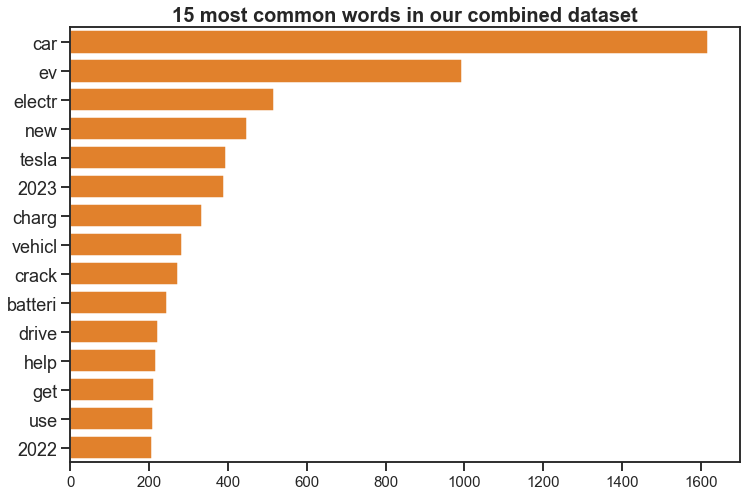

In [42]:
plt.figure(figsize=(12,8))
plt.title('15 most common words in our combined dataset', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=18)
sns.barplot(x=t_15.values, y=t_15.index, color='tab:orange')
plt.savefig('../images/common_words.png', dpi=300);

As expected from a combination of two subreddits with `car-related` themes, we have `car` and its variation `vehicl` (after being stemmed), showing up atop the list. 

## Now let's find the top words in the `electricvehicles` and `cars` subreddits respectively.

We'll start by resetting the index of our `ev_cars` dataframe so that it matches with the `title_vect_df` dataframe.

In [43]:
ev_cars.reset_index(drop=True, inplace=True)

In [44]:
title_df_evs = title_vect_df[ev_cars['subreddit']=='electricvehicles']
title_df_cars = title_vect_df[ev_cars['subreddit']=='cars']

In [45]:
#Top 15 words in r/electricvehicles
most_common_15_evs = title_df_evs.sum().sort_values(ascending=False).head(15)
most_common_15_evs

ev         923
electr     450
tesla      328
charg      319
car        288
new        215
batteri    211
vehicl     201
charger    192
2023       159
e          120
model      108
credit     107
tax        106
rang       103
dtype: int64

In [46]:
#Top 15 words in r/cars
most_common_15_cars = title_df_cars.sum().sort_values(ascending=False).head(15)
most_common_15_cars

car         1329
crack        273
new          233
2023         232
key          190
help         181
free         167
download     163
1            148
need         145
0            142
get          139
buy          132
use          127
3            126
dtype: int64

## Are there overlaps among the top words in the two subreddits - yes there are.

Of the 15 most common words in the cars and evs subreddits, 3 words are common to both.

In [47]:
for i in most_common_15_cars.index:
    if i in most_common_15_evs.index:
        print (f'Word: {i} \n Count in cars data: {most_common_15_cars[i]} \n Count in evs data: {most_common_15_evs[i]}')

Word: car 
 Count in cars data: 1329 
 Count in evs data: 288
Word: new 
 Count in cars data: 233 
 Count in evs data: 215
Word: 2023 
 Count in cars data: 232 
 Count in evs data: 159


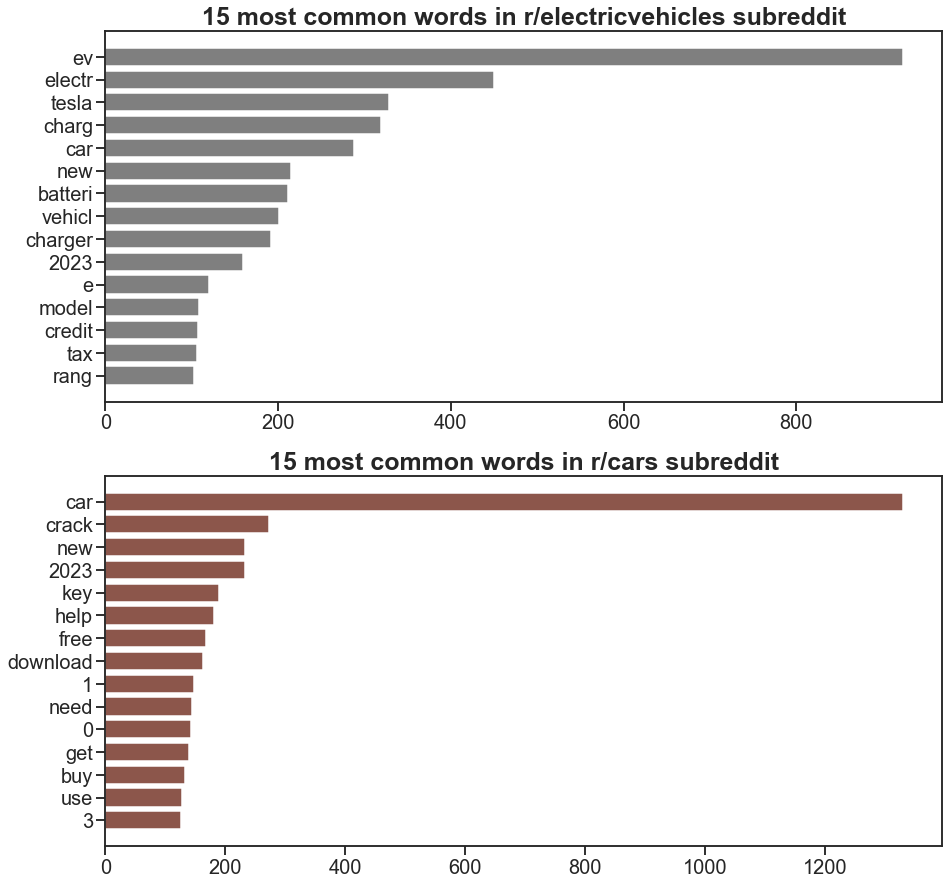

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
ax1.barh(most_common_15_evs.index[::-1], width = most_common_15_evs.sort_values(), color='tab:grey')
ax2.barh(most_common_15_cars.index[::-1], width = most_common_15_cars.sort_values(), color='tab:brown')
ax1.set_title('15 most common words in r/electricvehicles subreddit', {'fontsize':25, 'fontweight':'bold'})
ax2.set_title('15 most common words in r/cars subreddit', {'fontsize':25, 'fontweight': 'bold'})
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
plt.savefig('../images/common_ev_car.png', dpi=300);

**SHOULD I HAVE DROPPED `CARS` AND `ELECTRIC VEHICLES` FROM THE DATASETS SINCE THOSE ARE THE NAMES OF THE SUBREDDITS**

I considered this and decided against doing that because even though those are the names of the subreddits, they are not unique to either. Electric vehicles are cars as well, and as seen above, `car` shows up among the top 5 words in the `electricvehicle` dataset. So it doesn't give anything away. In fact it arguably makes it harder for the model. 

## Most common bigrams

I am also interested in seeing the most common bigrams in our dataset. So, I'll instantiate another CountVectorizer, specifying the ngram range as (2,2) in order to observe the top bigrams in our dataset. 

In [51]:
#Now I will instantiate CountVectorizer.
cvec = CountVectorizer(stop_words= stem_stopwords, tokenizer=my_stemmer, preprocessor=my_preprocessor, ngram_range=(2,2))

title_bi_vect = cvec.fit_transform(ev_cars.title)

title_bi = pd.DataFrame(title_bi_vect.todense(), columns=cvec.get_feature_names_out())

title_bi.shape

(7447, 32125)

In [52]:
most_common_bi = title_bi.sum().sort_values(ascending=False).head(15)
most_common_bi

free download    131
electr vehicl    126
electr car       103
key free         100
tax credit        82
new car           73
need help         53
ev charg          51
use car           49
crack serial      48
serial key        47
licens key        46
ken block         44
tesla model       40
first car         39
dtype: int64

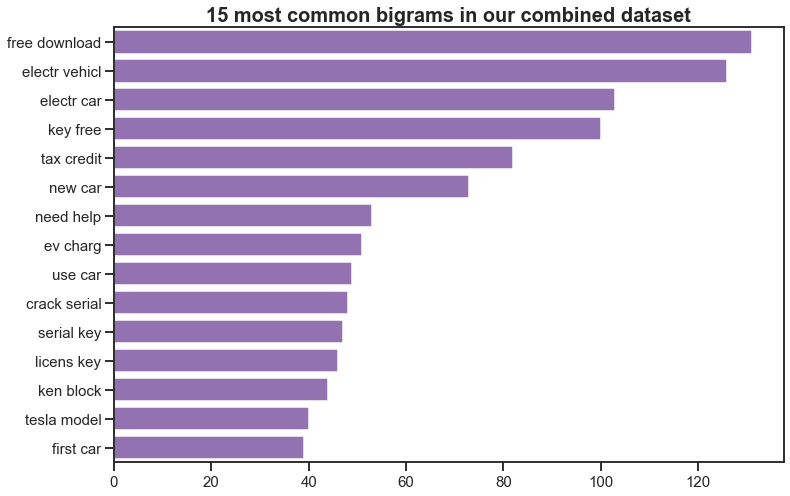

In [53]:
plt.figure(figsize=(12,8))
plt.title('15 most common bigrams in our combined dataset', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.barplot(x=most_common_bi.values, y=most_common_bi.index, color='tab:purple');

## I would like to check the top bigrams for the separate subreddits as well.

In [54]:
title_bi_evs = title_bi[ev_cars['subreddit']=='electricvehicles']
title_bi_cars = title_bi[ev_cars['subreddit']=='cars']

In [55]:
#Top 15 bigrams in r/electricvehicles
most_common_bi_evs = title_bi_evs.sum().sort_values(ascending=False).head(15)
most_common_bi_evs

electr vehicl        117
electr car            82
tax credit            80
ev charg              51
electrifi america     38
charg station         36
ev charger            34
tesla model           34
ev tax                31
e tron                31
ev batteri            30
model 3               29
fast charg            24
new ev                24
mach e                23
dtype: int64

In [56]:
#Top 15 bigrams in r/cars
most_common_bi_cars = title_bi_cars.sum().sort_values(ascending=False).head(15)
most_common_bi_cars

free download    131
key free         100
new car           60
need help         50
crack serial      48
serial key        47
licens key        46
ken block         44
use car           44
first car         39
crack full        36
crack plus        34
key 2023          29
anyon know        29
crack licens      29
dtype: int64

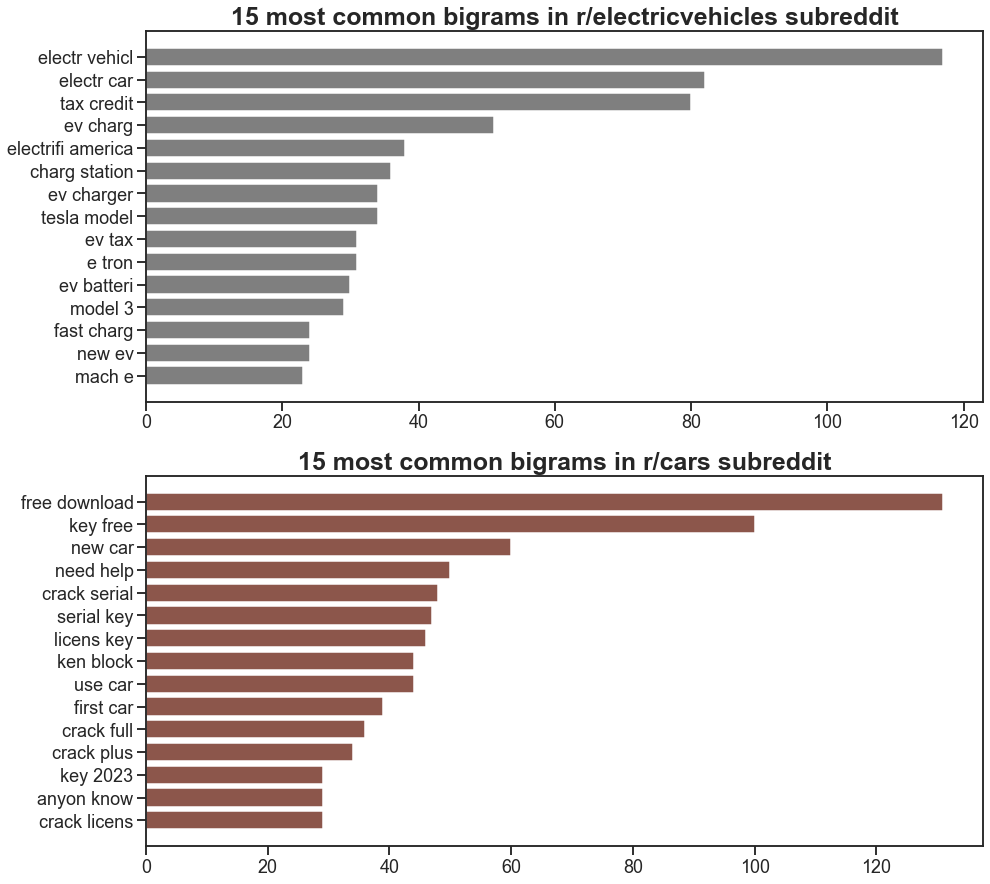

In [57]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
ax1.barh(most_common_bi_evs.index[::-1], width = most_common_bi_evs.sort_values(), color='tab:grey')
ax2.barh(most_common_bi_cars.index[::-1], width = most_common_bi_cars.sort_values(), color='tab:brown')
ax1.set_title('15 most common bigrams in r/electricvehicles subreddit', {'fontsize':25, 'fontweight':'bold'})
ax2.set_title('15 most common bigrams in r/cars subreddit', {'fontsize':25, 'fontweight':'bold'})
ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18);

When working on my models, I'll definitely use both unigrams and bigrams (and maybe trigams - we'll see). From the above, there are no common bigrams between the two subreddits. So I believe including bigrams in the n_gram_range of my CountVectorizer during analysis could be helpful to my model in separating the classes.

## EDA for Rivian

## Comparing mentions of `Rivian` with some of its competitors
At this point I'll like to do some EDA that'll give me a sense of how my employer - `Rivian` - shows up in the dataset. I noticed from my analysis of the top words that `tesla` shows up high up on the list as the most popular and most valuable ev company at this time. No other ev company shows up in that way. We are competitors with `tesla` and i would like to see how much we show up in comparison to Tesla and other ev brands. 

According to [this analysis](https://capital.com/amp/top-20-global-electric-vehicle-companies-ranking-tesla-ev-top-dog), these are the five biggest EV manufacturers in the world today. 

|Rank|Company|Ticker|MarketCap|Country|
|---|---|---|---|---|
|1|Tesla|TSLA|\\$355.90bn|US|
|2|Li Auto|LI|\\$19.52bn|China|
|3|NIO|NIO|\\$18.34bn|China|
|4|Rivian|RIVN|\\$15.67bn|US|
|5|Lucid Motors|LCID|\\$10.72bn|US|

**NB:** There are big auto companies like GM or Toyota which also manufacture electric vehicles, but the companies listed above only produce electric vehicles. 

I'll compare mentions of `Rivian` with its competitors on that list.

In [58]:
labels = ['tesla', 'rivian', 'lucid', 'nio', 'li']
ev_counts = []
car_counts = []
for l in labels:
    ev_count = title_df_evs[l].sum()
    car_count = title_df_cars[l].sum()
    ev_counts.append(ev_count)
    car_counts.append(car_count)

In [59]:
ev_counts

[328, 60, 41, 14, 1]

In [60]:
car_counts

[68, 9, 5, 0, 0]

In [61]:
#Making a datframe out of the above information
counts_df = pd.DataFrame(
{'Company': ['Tesla', 'Rivian', 'Lucid', 'NIO', 'LI'],
 'EV': ev_counts, 
'Cars': car_counts})

counts_df

,Company,EV,Cars
0,Tesla,328,68
1,Rivian,60,9
2,Lucid,41,5
3,NIO,14,0
4,LI,1,0


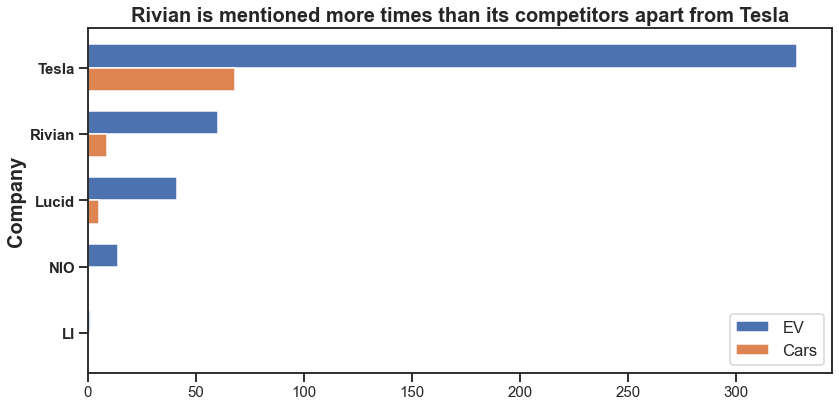

In [62]:
#sns.set_theme(rc={'figure.figsize': (10,5)}, style='ticks', context='talk')

p = counts_df.plot(x = 'Company',
                   kind='barh', 
                   stacked=False, 
                   figsize=(12,6), 
                   fontsize=15, width = 0.7)

p.invert_yaxis()
plt.legend(loc='lower right')
plt.title('Rivian is mentioned more times than its competitors apart from Tesla', size=20, fontweight='bold')
plt.ylabel('Company', size=20, fontweight='bold'),
plt.yticks(fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/rivian.png', dpi=300);

`Rivian` is not mentioned too many times in the subreddits, but it appears more times than three of its main competitors. However its mentions are dwarfed by that of `Tesla`, the market leader, which is mentioned 5 times more than `Rivian` in the `electricvehicles` subreddit, and 7 times more in the `cars` subreddit.

There would be time in future to consider the sentiments of Rivian's mentions, but for now the task is to classify the mentions into one of the two classes. 

For now, I would move on to preprocessing and modeling.

## One last thing

## Saving the cleaned `ev_cars` dataset as csv file

In [63]:
ev_cars.tail()

,subreddit,title
7442,electricvehicles,China EV Sales: BYD Achieves All-Electric Mile...
7443,electricvehicles,BMW i3 - considering buying a 2015
7444,electricvehicles,DRAG RACING OUR GOLF CARTS! They say electric ...
7445,electricvehicles,Ceer Is Saudi Arabia's First Homegrown EV Bran...
7446,electricvehicles,Quantumscape Announces New Cell Format for Sol...


In [64]:
ev_cars.shape

(7447, 2)

In [61]:
ev_cars.to_csv('../data/ev_cars_cleaned.csv', index=False)